# **Introduction**

This notebook is for implementing a Deep Q-Network (DQN) algorithm for the ``cartpole`` environment offered through Gymnasium. Gymnasium is an open source Python library for developing and comparing reinforcement learning algorithms, through the use of a standardized API.

# **Import Packages**

This section imports the necessary packages:

In [176]:
# import these packages:
import gymnasium as gym
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

from collections import deque

# **Environment Setup**

This section sets up the environment and defines the relevant functions needed for this implementation.

##### Function for Making Keras Models:

In [177]:
# function for making a keras model:
def make_model(layers, neurons, rate, norm, drop, input_shape, output_shape, loss_function):
    # instantiate model:
    model = keras.Sequential()

    # add hidden layers:
    for i in range(layers):
        if i == 0:
            model.add(Input(shape = (input_shape, )))
            model.add(Dense(neurons, activation = 'relu', name = f'hidden_layer_{i+1}'))
        else:
            model.add(Dense(neurons, activation = 'relu', name = f'hidden_layer_{i+1}'))

        if norm == True:
            model.add(BatchNormalization(name = f'batch_norm_layer_{i+1}'))

        if drop == True:
            model.add(Dropout(0.2, name = f'dropout_layer_{i+1}'))
    
    # add output layer:
    model.add(Dense(output_shape, activation = 'linear', name = 'output_layer'))

    # compile the model:
    model.compile(optimizer = Adam(learning_rate = rate),
                  loss = loss_function)
    
    return model 

##### DQN Class:

In [178]:

# DQN agent class:
class DQN_Agent:
    ####################### INITIALIZATION #######################
    # constructor:
    def __init__(self, 
        env: gym.Env, 
        gamma: float, 
        alpha: float,
        epsilon: float,
        epsilon_min: float,
        epsilon_decay: float,
        batch_size: int,
        buffer_size: int,
        target_update_freq: int, 
        layers = int,
        neurons = int):
        """ 
        this is the constructor for the agent. this agent uses a DQN to learn an optimal policy, through the use of approximator neural network 
        to approximate action-value Q, and a target network to generate a Q-target used in the updating of Q(s,a). this is done to prevent updates
        to the network weights from changing the target, meaning that we aren't bootstrapping towards a changing target. this helps to stabilize the learning.

        env:                    a gymnasium environment
        gamma:                  a float value indicating the discount factor
        alpha:                  a float value indicating the learning rate
        epsilon:                a float value indicating the action-selection probability ε
        epsilon_min:            a float value indicating the minimum ε value
        epsilon_decay:          a float value indicating the decay rate of ε
        batch_size:             an int representing the batch size sampled from the experience
        buffer_size:            an int representing the size of the memory buffer
        target_update_freq:     an int representing how frequently the target network weights should be updated
        layers:                 an int representing the number of layers in each network
        neurons:                an int representing the number of neurons in each network

        nS:         an int representing the number of states observed, each of which is continuous
        nA:         an int representing the number of discrete actions that can be taken

        approximator_network:       a Keras sequential neural network representing the actual function approximator
        target_network:             a Keras sequential neural network representing responsible for generating Q-targets
        experience:                 an empty deque used to hold the experience history of the agent, limited to buffer_size


        """
        # object parameters:
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # get the environment dimensions:
        self.nS = self.env.observation_space.shape[0]
        self.nA = self.env.action_space.n

        # experience history and mini-batch size:
        self.buffer_capacity = buffer_size
        self.state_buffer = np.zeros((buffer_size, self.nS), dtype = np.float32)
        self.next_state_buffer = np.zeros((buffer_size, self.nS), dtype = np.float32)
        self.action_buffer = np.zeros(buffer_size, dtype = np.int32)
        self.reward_buffer = np.zeros(buffer_size, dtype = np.float32)
        self.done_buffer = np.zeros(buffer_size, dtype = np.float32)

        self.buffer_count = 0   # total experiences stored
        self.buffer_ptr = 0     # next index to write to

        self.batch_size = batch_size
        self.step_counter = 0

        # initialize networks:
        self.approximator_network = make_model(layers = layers, neurons = neurons, rate = alpha,
                                                norm = False, drop = False,
                                                input_shape = self.nS, output_shape = self.nA,
                                                loss_function = 'mse')
        self.target_network = keras.models.clone_model(self.approximator_network)
        self.target_network.set_weights(self.approximator_network.get_weights())

        # set target network update frequency:
        self.target_update_freq = target_update_freq

    ####################### INITIALIZATION #######################
    # function to store experience in the replay buffer:
    def store(self, state, action, reward, next_state, done):
        """
        this function populates the replay buffer from transitions in a given step:

        state:          the current state
        action:         the action taken from the current state
        reward:         the reward received from the action taken in the state
        next_state:     the resulting next state from the action taken in the current state
        done:           whether or not the episode terminated
        
        """
        index = self.buffer_ptr
        self.state_buffer[index] = state
        self.action_buffer[index] = action
        self.reward_buffer[index] = reward
        self.next_state_buffer[index] = next_state
        self.done_buffer[index] = 1.0 if done else 0.0

        self.buffer_ptr  = (index + 1) % self.buffer_capacity
        self.buffer_count = min(self.buffer_count + 1, self.buffer_capacity)

    @tf.function
    def predict_q(self, state):
        return self.approximator_network(state)
    
    def greedy(self, state):
        if random.random() > self.epsilon:
            q = self.predict_q(tf.convert_to_tensor([state])).numpy()[0]
            return np.argmax(q)
        else:
            return self.env.action_space.sample() 
    
    # ε-decay function:
    def decay_epsilon(self):
        """ 
        this function decays epsilon according to a schedule:
    
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    @tf.function
    def train_step(self, states, actions, rewards, next_states, dones):
        # states:           (B, nS)
        # actions:          (B,) int32
        # rewards:          (B,) float32
        # next_states:      (B,) float32
        # dones:            (B,) float32

        with tf.GradientTape() as tape:
            # 1) do a forward pass:
            q_all = self.approximator_network(states)
            index = tf.stack([tf.range(tf.shape(actions)[0]), actions], axis = 1)
            q_selected = tf.gather_nd(q_all, index)

            # 2) compute TD-targets:
            q_next = self.target_network(next_states)
            max_q_next = tf.reduce_max(q_next, axis = 1)
            targets = rewards + (1 - dones) * self.gamma * max_q_next

            # 3) MSE loss on only the Qs that correspond to taken actions:
            loss = tf.reduce_mean(tf.square(q_selected - targets))

        # 4) backpropagate and update weights:
        grads = tape.gradient(loss, self.approximator_network.trainable_weights)
        self.approximator_network.optimizer.apply_gradients(zip(grads, self.approximator_network.trainable_variables))

    # training function:
    def train(self, num_episodes):
        """
        this function performs the actual training loop for the network:

        num_episodes:   the desired number of training episodes
        
        """
        # pre-compute reward history:
        reward_history = np.zeros(num_episodes)

        # for every episode:
        for episode in tqdm(range(num_episodes), colour = "#33FF00", ncols = 100):
            # reset the environment:
            obs, _ = self.env.reset()
            episode_reward = 0

            # flag for completion:
            done = False

            # while false:
            while not done:
                # select action based on ε-greedy implicit "policy":
                action = self.greedy(obs)

                # take the action:
                next_obs, reward, term, trunc, _ = self.env.step(action)

                # check for completion:
                done = term or trunc

                # append transitions to replay buffer:
                self.store(obs, action, reward, next_obs, done)

                # advance the state:
                obs = next_obs
                episode_reward += reward
                self.step_counter += 1

                # sample a batch and update the network:
                if self.buffer_count >= self.batch_size and self.step_counter % 4 == 0:
                    # get valid indices:
                    max_index = min(self.buffer_count, self.buffer_capacity)
                    indices = np.random.choice(max_index, size = self.batch_size, replace = False)
                    
                    # fetch batch from  pre-allocated arrays:
                    states = tf.convert_to_tensor(self.state_buffer[indices], dtype = tf.float32)
                    actions = tf.convert_to_tensor(self.action_buffer[indices], dtype = tf.int32)
                    rewards = tf.convert_to_tensor(self.reward_buffer[indices], dtype = tf.float32)
                    next_states = tf.convert_to_tensor(self.next_state_buffer[indices], dtype = tf.float32)
                    dones = tf.convert_to_tensor(self.done_buffer[indices], dtype = tf.float32)

                    # single graph call:
                    self.train_step(states, actions, rewards, next_states, dones)           

                    # update target network periodically:
                    if self.step_counter % self.target_update_freq == 0:
                        self.target_network.set_weights(self.approximator_network.get_weights())

            # decay epsilon:
            self.decay_epsilon()

            # append reward to history:
            reward_history[episode] = episode_reward
        
        return reward_history


# **Using the Environment**

This section utilizes the above DQN to create an environment and train an agent.

In [179]:
# agent hyperparameters:
num_episodes = 500
gamma = 0.99
alpha = 1e-3
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 128
buffer_size = 5000
target_update_freq = 100
layers = 2
neurons = 64

# create the environment:
env = gym.make("CartPole-v1")

# clear backend:
tf.keras.backend.clear_session()

# instantiate the agent:
dqn_agent = DQN_Agent(env = env, 
                  gamma = gamma, 
                  alpha = alpha,
                  epsilon = epsilon,
                  epsilon_min = epsilon_min,
                  epsilon_decay = epsilon_decay,
                  batch_size = batch_size, 
                  buffer_size = buffer_size,
                  target_update_freq = target_update_freq, 
                  layers = layers,
                  neurons = neurons)


##### **Warm up the Experience Buffer**

In [180]:
# set minimum amount of samples we want:
warm_length = 1000

# fill buffer with some random experience to warm it up:
obs, _ = dqn_agent.env.reset()
for _ in tqdm(range(warm_length), colour = "#33FF00", ncols = 100):
    # randomly sample the action space, equivalent to ε = 1.0:
    action = dqn_agent.env.action_space.sample()

    # take the action:
    next_obs, reward, term, trunc, _ = dqn_agent.env.step(action)

    # check completion:
    done = term or trunc

    # populate replay buffer:
    dqn_agent.store(obs, action, reward, next_obs, done)

    # advance state:
    obs = next_obs if not done else env.reset()[0]


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 58825.32it/s]


##### **Train the Network**

This section trains the network using its training method.

In [181]:
# call the training method:
reward_history = dqn_agent.train(num_episodes = num_episodes)

100%|█████████████████████████████████████████████████████████████| 500/500 [02:19<00:00,  3.59it/s]


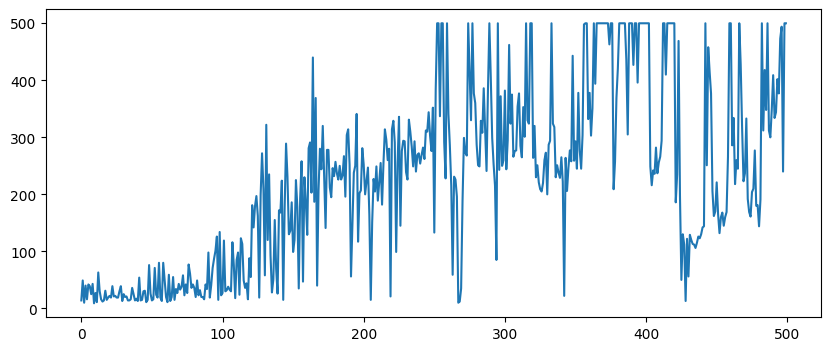

In [182]:
figure = plt.figure(figsize = (10,4))
plt.plot(reward_history)